In [4]:
from Systems import UnbalancedDisc
from Systems import NoisyUnbalancedDisc
from Systems import OutputUnbalancedDisc
import Systems
import deepSI
from matplotlib import pyplot as plt
import numpy as np
#import autograd
import torch
import time
from torch import nn
#import quadprog as qp
import qpsolvers as qp

In [5]:
system = Systems.NoisyUnbalancedDisc(dt=0.1, sigma_n=[0, 0])
encoder = deepSI.load_system("systems/ObserverUnbalancedDisk_dt01_nab_4_SNR_30_e250")

In [6]:
u = deepSI.deepSI.exp_design.multisine(100000, pmax=49999, n_crest_factor_optim=20)
u = np.clip(u*1.0, -3.0, 3.0)

In [7]:
data = system.apply_experiment(deepSI.System_data(u=u),save_state=True)

In [8]:
data_normed = encoder.norm.transform(data)

In [9]:
test_ss_enc = encoder.apply_experiment(deepSI.System_data(u=u),save_state=True)

In [10]:
test_ss_enc_normed = encoder.norm.transform(test_ss_enc)

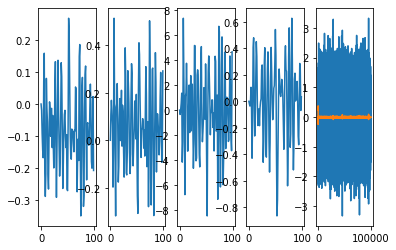

In [11]:
plt.subplot(1,5,1)
plt.plot(test_ss_enc_normed.x[:100,0])
plt.subplot(1,5,2)
plt.plot(test_ss_enc_normed.x[:100,1])

plt.subplot(1,5,3)
plt.plot(data_normed.x[:100,0])
plt.subplot(1,5,4)
plt.plot(data_normed.x[:100,1])

plt.subplot(1,5,5)
plt.plot(data_normed.y[:,1])
plt.plot(data_normed.y[:,1] - test_ss_enc_normed.y)

In [12]:
# function that converts torch nn to casadi expression
from casadi import *

def CasADiHn(ss_enc, x):
    n_hidden_layers = 2#ss_enc.h_n_hidden_layers

    params = {}
    for name, param in ss_enc.hn.named_parameters():
        params[name] = param.detach().numpy()
    params_list = list(params.values())

    temp_nn = x
    for i in range(n_hidden_layers):
        W_NL = params_list[2+i*2]
        b_NL = params_list[3+i*2]
        temp_nn = mtimes(W_NL, temp_nn)+b_NL
        temp_nn = tanh(temp_nn)
    W_NL = params_list[2+n_hidden_layers*2]
    b_NL = params_list[3+n_hidden_layers*2]
    nn_NL = mtimes(W_NL, temp_nn)+b_NL

    W_Lin = params_list[0]
    b_Lin = params_list[1]
    nn_Lin = mtimes(W_Lin,x) + b_Lin

    return nn_NL + nn_Lin

def CasADiFn(ss_enc, x, u):
    n_hidden_layers = 2#ss_enc.f_n_hidden_layers

    params = {}
    for name, param in ss_enc.fn.named_parameters():
        params[name] = param.detach().numpy()
    params_list = list(params.values())
    
    xu = vertcat(x,u)

    temp_nn = xu
    for i in range(n_hidden_layers):
        W_NL = params_list[2+i*2]
        b_NL = params_list[3+i*2]
        temp_nn = mtimes(W_NL, temp_nn)+b_NL
        temp_nn = tanh(temp_nn)
    W_NL = params_list[2+n_hidden_layers*2]
    b_NL = params_list[3+n_hidden_layers*2]
    nn_NL = mtimes(W_NL, temp_nn)+b_NL

    W_Lin = params_list[0]
    b_Lin = params_list[1]
    nn_Lin = mtimes(W_Lin,xu) + b_Lin

    return nn_NL + nn_Lin

In [13]:
# declared sym variables
x = MX.sym("x",encoder.nx,1)
nu = encoder.nu if encoder.nu is not None else 1
u = MX.sym("u",nu,1)

# convert torch nn to casadi function
rhs = CasADiFn(encoder, x, u)
f = Function('f', [x, u], [rhs])

y_rhs = CasADiHn(encoder, x)
h = Function('h', [x], [y_rhs])

# apply correction to casadi function such that fc(0) = 0
correction_f = f([0,0], 0)
rhs_c = rhs - correction_f
correction_h = h([0,0])
y_rhs_c = y_rhs - correction_h
f_c = Function('f_c', [x, u], [rhs_c])
h_c = Function('h_c', [x], [y_rhs_c])

In [14]:
Jfx = Function("Jfx", [x, u], [jacobian(rhs_c,x)])
Jfu = Function("Jfu", [x, u], [jacobian(rhs_c,u)])
Jhx = Function("Jhx", [x, u], [jacobian(y_rhs_c,x)])

In [15]:
from lpv_int import *
stages = 100
dlam = 1.0/stages
nx = 2; ny = 1
[A, B, C] = lpv_int_C(x,nx,u,nu,ny,Jfx,Jfu,Jhx,dlam,stages)
get_A = Function("get_A",[x,u],[A])
get_B = Function("get_B",[x,u],[B])
get_C = Function("get_C",[x,u],[C])

In [16]:
xs = np.zeros(nx)
us = np.zeros(nu)
C = np.zeros((ny,nx))
C[:,:] = get_C(xs, us)
C

array([[-5.23925331, -2.59772804]])

In [17]:
nb = 2
uhist = torch.zeros((1,nb))#torch.tensor([[0,0]],dtype=torch.float32)
na = 2
yhist = torch.zeros((1,na+1))#torch.tensor([[0,0,0]],dtype=torch.float32)
i = 0
Nsim = 200

ylog = np.zeros(Nsim)
yestlog = np.zeros(Nsim)
yclog = np.zeros(Nsim)

In [18]:
for i in range(Nsim):
    system.x = system.f(system.x, data.u[i])
    y = system.h(system.x, data.u[i])[1]
    ylog[i] = y

    for j in range(nb-1):
        uhist[0,j] = uhist[0,j+1]
    uhist[0,nb-1] = torch.Tensor([data_normed.u[i]])

    for j in range(na):
        yhist[0,j] = yhist[0,j+1]
    
    y_norm = (y - encoder.norm.y0)/encoder.norm.ystd
    yhist[0,na] = torch.Tensor([y_norm])

    zest = encoder.encoder(uhist,yhist)
    
    yest = encoder.hn(zest)
    yest_un = encoder.norm.ystd*yest + encoder.norm.y0
    yestlog[i] = yest_un

    C[:,:] = get_C(zest.detach().tolist()[0], data_normed.u[i])
    temp = C@(zest.detach().numpy().T) + correction_h.elements()[0]
    yclog[i] = encoder.norm.ystd*temp + encoder.norm.y0

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x5 and 9x2)

Text(0.5, 0, 'time [s]')

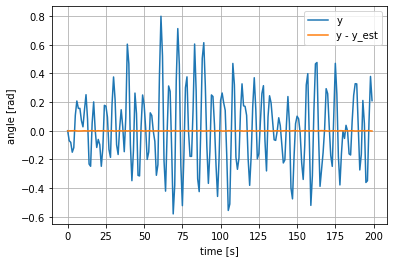

In [23]:
plt.plot(ylog, label='y')
plt.plot(ylog - yclog, label='y - y_est')
plt.grid()
plt.legend()
plt.ylabel("angle [rad]")
plt.xlabel("time [s]")